In [1]:
import time
import os
import joblib
import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [2]:
filepath = 'bitcoin.csv'
data = pd.read_csv(os.path.join('./data', filepath))
data = data.sort_values('Date')
price = data[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price.loc[:, 'Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [3]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    lookback+=1
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train[:,:,0], y_train, x_test[:,:,0], y_test]

In [4]:
def get_train_test_data(data, sequence: int=20, verbose=True, poly_degree=1):
    x_train, y_train, x_test, y_test = split_data(data, sequence)
    if poly_degree > 1:
        poly = PolynomialFeatures(poly_degree)
        x_train = poly.fit_transform(x_train)
        x_test  = poly.fit_transform(x_test)
    if verbose:
        print('x_train.shape = ',x_train.shape)
        print('y_train.shape = ',y_train.shape)
        print('x_test.shape = ',x_test.shape)
        print('y_test.shape = ',y_test.shape)
    return x_train, y_train, x_test, y_test

## SVR

In [5]:
sequence_len = [1, 2, 5, 10, 15, 20, 25]
svr_grid_search = []
for i in range(len(sequence_len)):
    svr_grid_search.append(joblib.load('models/svr/gs_'+str(sequence_len[i])+'seq.pkl'))

In [6]:
params = ['C', 'coef0', 'degree', 'epsilon', 'kernel']
search_params = ['_'.join(['param',param]) for param in params]

In [7]:
for i in range(len(sequence_len)):
    print(svr_grid_search[i].best_score_)

-111.68169774253029
-111.86781200731471
-22.866397301346975
-2.9668467913959686
-81.30228463037835
-65.84761493497095
-12.226666972879704


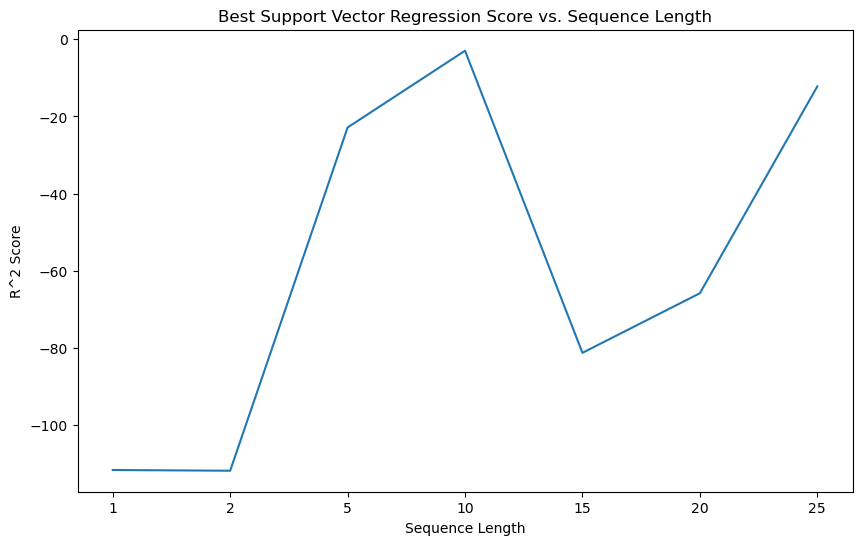

In [8]:
best_acc = []
for i in range(len(sequence_len)):
    best_acc.append(svr_grid_search[i].best_score_)

ax = plt.figure(figsize=(10,6))
plt.plot(best_acc)
plt.ylabel('R^2 Score')
plt.xlabel('Sequence Length')
plt.xticks(range(len(sequence_len)), [str(s) for s in sequence_len]);
plt.title('Best Support Vector Regression Score vs. Sequence Length')
plt.savefig('figures/svr/best_score_vs_len.png')

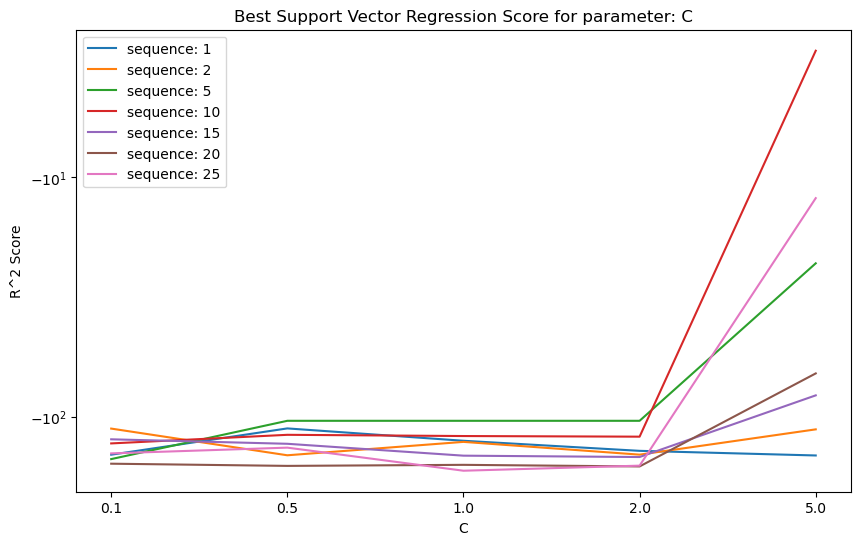

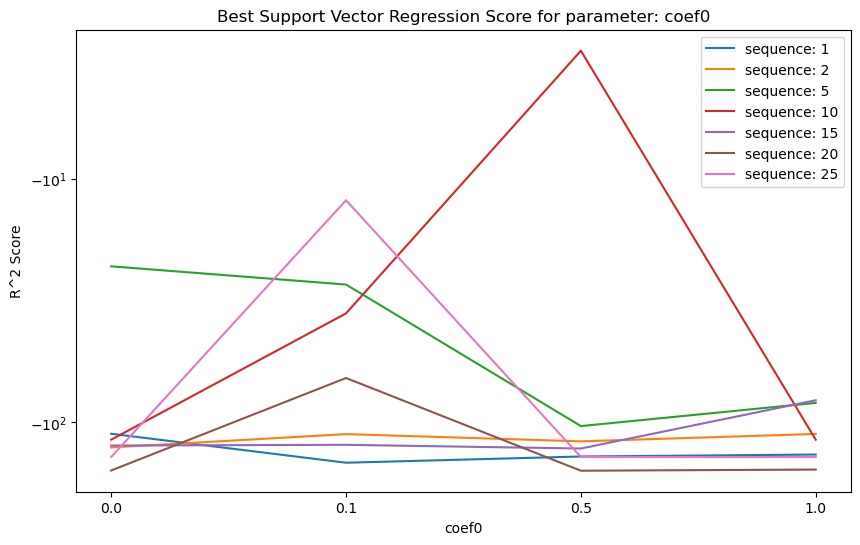

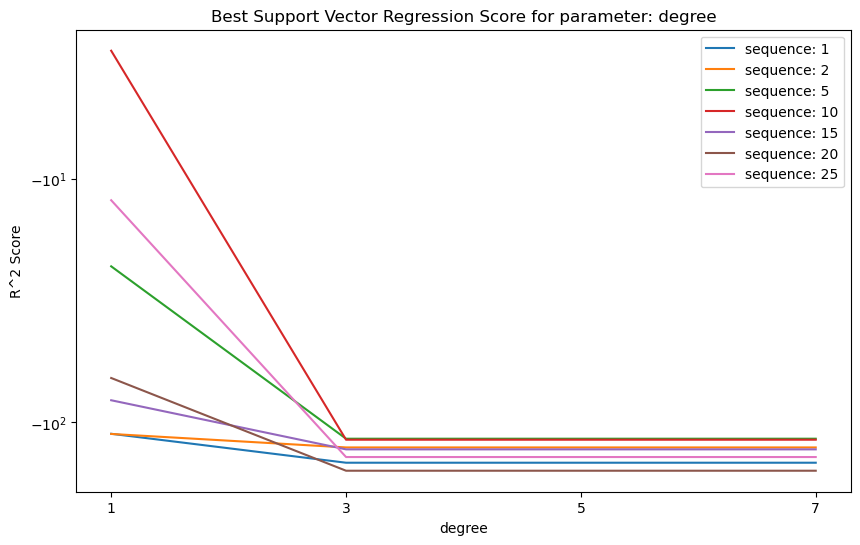

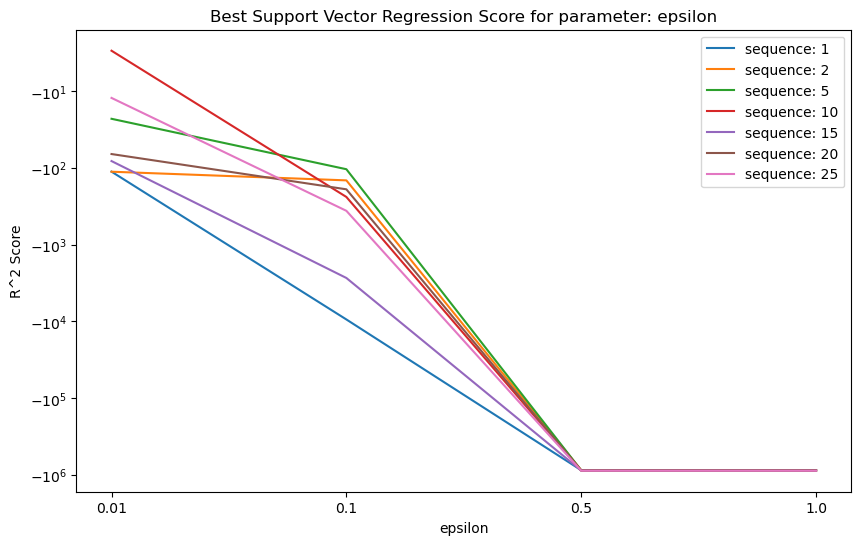

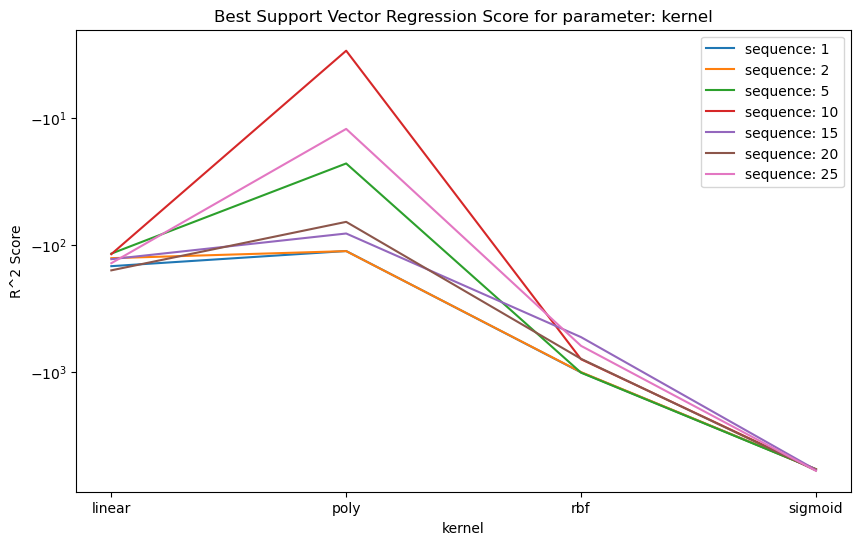

In [9]:
for j in range(len(search_params)):
    param = search_params[j]
    fig = plt.figure(figsize=(10,6))
    index = pd.DataFrame(svr_grid_search[0].cv_results_).groupby(param)['mean_test_score'].max().index
    for i in range(len(sequence_len)):
        temp = pd.DataFrame(svr_grid_search[i].cv_results_)
        vals = temp.groupby(param)['mean_test_score'].max()
        plt.plot(vals.values, label='sequence: '+str(sequence_len[i]))
    plt.legend()
    plt.title('Best Support Vector Regression Score for parameter: '+params[j])
    plt.yscale('symlog')
    plt.xlabel(params[j])
    plt.ylabel('R^2 Score')
    plt.xticks(list(range(len(index))), index)
    plt.savefig('figures/svr/best_score_vs_'+param+'.png')
    plt.show()

### Best SVR's predictions

In [10]:
best_score = -1*np.inf
best_svr = None
best_len = 0
for i in range(len(svr_grid_search)):
    seq_len = sequence_len[i]
    model = svr_grid_search[i]
    score = model.best_score_
    print('Best Model for Sequence Length:', seq_len)
    print('                         Score:', score)
    if score > best_score:
        best_score = score
        best_svr = model
        best_len = seq_len

Best Model for Sequence Length: 1
                         Score: -111.68169774253029
Best Model for Sequence Length: 2
                         Score: -111.86781200731471
Best Model for Sequence Length: 5
                         Score: -22.866397301346975
Best Model for Sequence Length: 10
                         Score: -2.9668467913959686
Best Model for Sequence Length: 15
                         Score: -81.30228463037835
Best Model for Sequence Length: 20
                         Score: -65.84761493497095
Best Model for Sequence Length: 25
                         Score: -12.226666972879704


In [11]:
print('     Best Score:', best_score)
print('Sequence Length:', best_len)

     Best Score: -2.9668467913959686
Sequence Length: 10


In [12]:
best_svr.best_params_

{'C': 5.0, 'coef0': 0.5, 'degree': 1, 'epsilon': 0.01, 'kernel': 'poly'}

In [13]:
x_train,y_train,x_test,y_test = get_train_test_data(price, best_len)

x_train.shape =  (3527, 10)
y_train.shape =  (3527, 1)
x_test.shape =  (882, 10)
y_test.shape =  (882, 1)


In [14]:
print('Best Model Accuracy:', best_svr.best_estimator_.score(x_test, y_test))

Best Model Accuracy: 0.9922975820974299


In [15]:
y_test_pred = best_svr.predict(x_test)

In [16]:
y_test.shape

(882, 1)

In [17]:
y_test_pred.reshape(-1,1).shape

(882, 1)

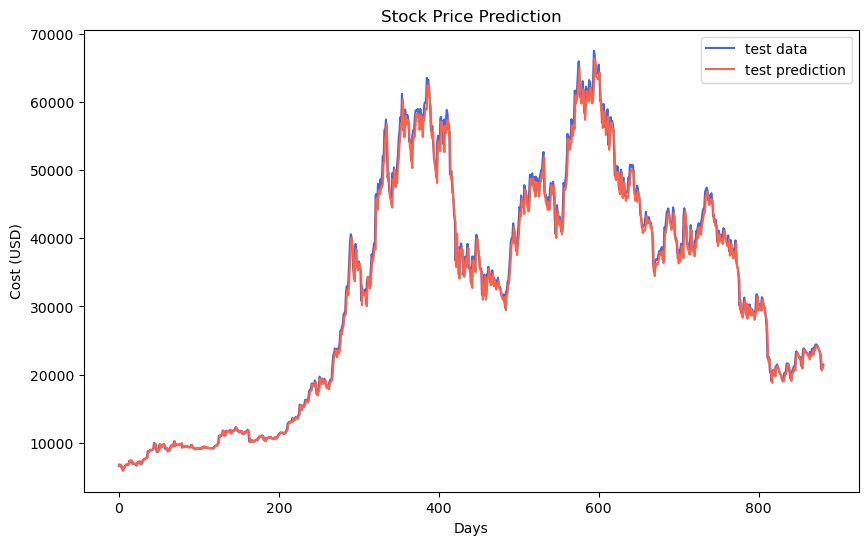

In [18]:
fig = plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(y_test), color='royalblue', label='test data')
plt.plot(scaler.inverse_transform(y_test_pred.reshape(-1,1)), color='tomato', label='test prediction')
plt.title('Stock Price Prediction')
plt.ylabel('Cost (USD)')
plt.xlabel('Days')
plt.legend()
plt.savefig('figures/svr/test_prediction.png')

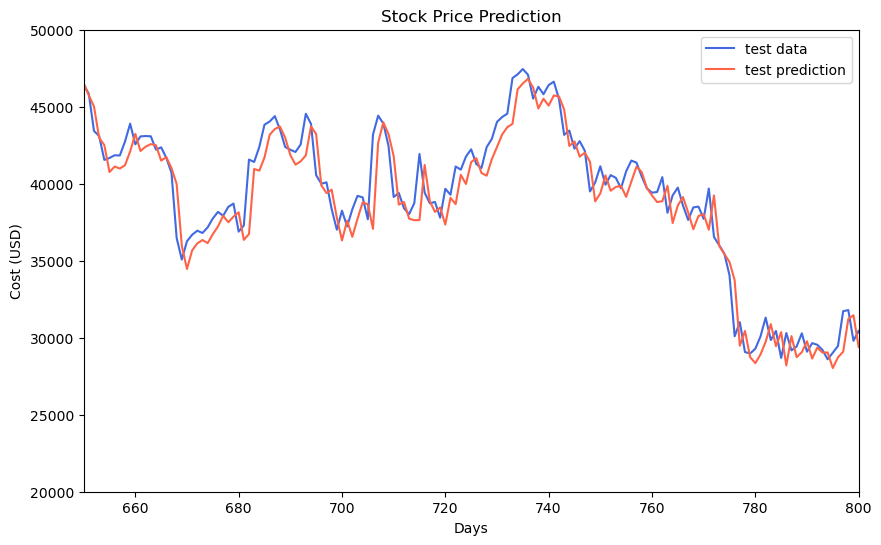

In [19]:
fig = plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(y_test), color='royalblue', label='test data')
plt.plot(scaler.inverse_transform(y_test_pred.reshape(-1,1)), color='tomato', label='test prediction')
plt.title('Bitcoin Price Prediction')
plt.ylabel('Cost (USD)')
plt.xlabel('Days')
plt.legend()
plt.xlim(left=650, right=800)
plt.ylim(bottom=20000, top=50000)
plt.savefig('figures/svr/test_prediction_zoom.png')

## Polynomial Regression

In [20]:
sequence_len = [1, 2, 5, 10, 15, 20, 25]
poly_degree = [1, 2, 5]

lr_grid_search = []
for i in range(len(sequence_len)):
    for j in range(len(poly_degree)):
        s = sequence_len[i]
        d = poly_degree[j]
        print('models/lr/gs_'+str(s)+'seq_'+str(d)+'deg.pkl')
        lr_grid_search.append(joblib.load('models/lr/gs_'+str(s)+'seq_'+str(d)+'deg.pkl'))

models/lr/gs_1seq_1deg.pkl
models/lr/gs_1seq_2deg.pkl
models/lr/gs_1seq_5deg.pkl
models/lr/gs_2seq_1deg.pkl
models/lr/gs_2seq_2deg.pkl
models/lr/gs_2seq_5deg.pkl
models/lr/gs_5seq_1deg.pkl
models/lr/gs_5seq_2deg.pkl
models/lr/gs_5seq_5deg.pkl
models/lr/gs_10seq_1deg.pkl
models/lr/gs_10seq_2deg.pkl
models/lr/gs_10seq_5deg.pkl
models/lr/gs_15seq_1deg.pkl
models/lr/gs_15seq_2deg.pkl
models/lr/gs_15seq_5deg.pkl
models/lr/gs_20seq_1deg.pkl
models/lr/gs_20seq_2deg.pkl
models/lr/gs_20seq_5deg.pkl
models/lr/gs_25seq_1deg.pkl
models/lr/gs_25seq_2deg.pkl
models/lr/gs_25seq_5deg.pkl


In [21]:
for i in range(len(sequence_len)):
    for j in range(len(poly_degree)):
        m = lr_grid_search[len(poly_degree)*i+j]
        print(sequence_len[i], ',', poly_degree[j], ':', m.n_features_in_)

1 , 1 : 1
1 , 2 : 3
1 , 5 : 6
2 , 1 : 2
2 , 2 : 6
2 , 5 : 21
5 , 1 : 5
5 , 2 : 21
5 , 5 : 252
10 , 1 : 10
10 , 2 : 66
10 , 5 : 3003
15 , 1 : 15
15 , 2 : 136
15 , 5 : 15504
20 , 1 : 20
20 , 2 : 231
20 , 5 : 53130
25 , 1 : 25
25 , 2 : 351
25 , 5 : 142506


In [22]:
params = ['alpha']
search_params = ['_'.join(['param',param]) for param in params]

In [23]:
for i in range(len(sequence_len)):
    print(lr_grid_search[i].best_score_)

0.40506931530734436
0.7448936617495435
0.8714086944037305
0.4054975946962194
0.545109104559297
0.7984402870686939
0.4024489024889458


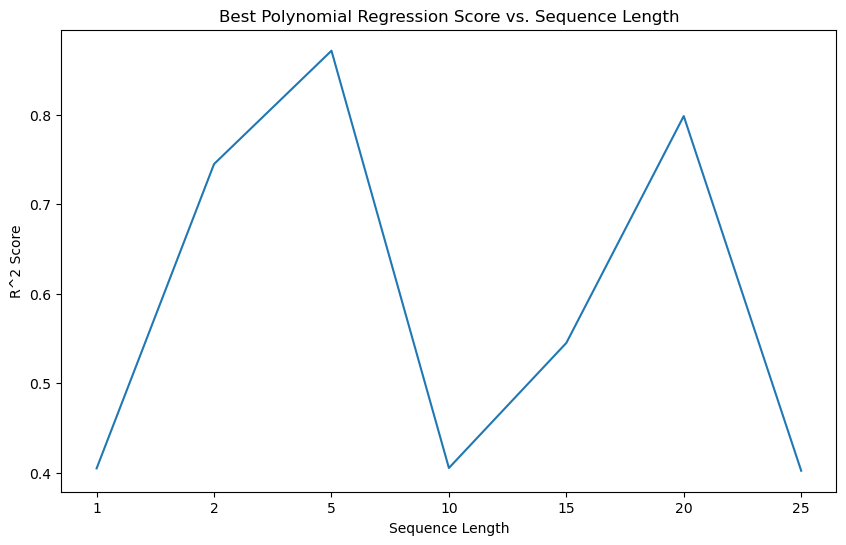

In [24]:
best_acc = []
for i in range(len(sequence_len)):
    best_acc.append(lr_grid_search[i].best_score_)

ax = plt.figure(figsize=(10,6))
plt.plot(best_acc)
plt.ylabel('R^2 Score')
plt.xlabel('Sequence Length')
plt.xticks(range(len(sequence_len)), [str(s) for s in sequence_len]);
plt.title('Best Polynomial Regression Score vs. Sequence Length')
plt.savefig('figures/lr/best_score_vs_len.png')

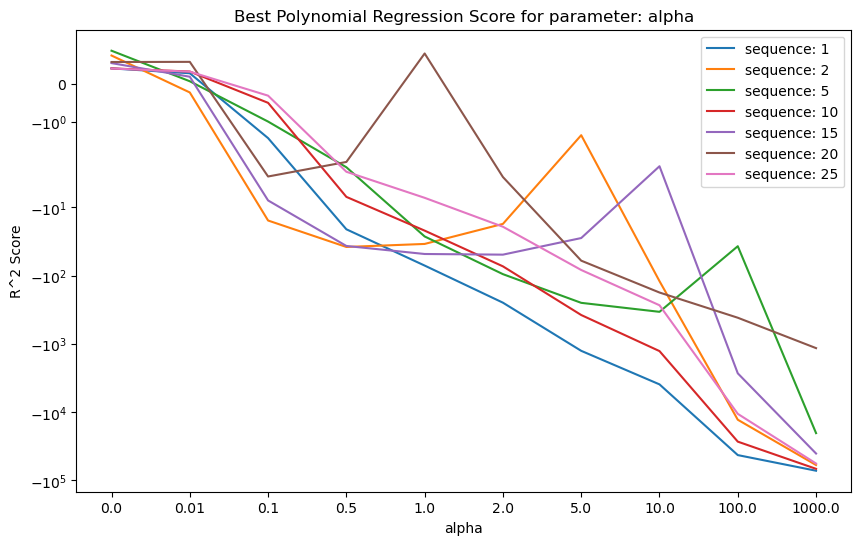

In [25]:
for j in range(len(search_params)):
    param = search_params[j]
    fig = plt.figure(figsize=(10,6))
    index = pd.DataFrame(lr_grid_search[0].cv_results_).groupby(param)['mean_test_score'].max().index
    for i in range(len(sequence_len)):
        temp = pd.DataFrame(lr_grid_search[i].cv_results_)
        vals = temp.groupby(param)['mean_test_score'].max()
        plt.plot(vals.values, label='sequence: '+str(sequence_len[i]))
    plt.legend()
    plt.title('Best Polynomial Regression Score for parameter: '+params[j])
    plt.yscale('symlog')
    plt.xlabel(params[j])
    plt.ylabel('R^2 Score')
    plt.xticks(list(range(len(index))), index)
    plt.savefig('figures/lr/best_score_vs_'+param+'.png')
    plt.show()

### Best Polynomial Regression predictions

In [26]:
best_score = -1*np.inf
best_lr = None
best_len = 0
best_degree = 0

for i in range(len(sequence_len)):
    for j in range(len(poly_degree)):
        seq_len = sequence_len[i]
        poly_deg = poly_degree[j]
        model = lr_grid_search[len(poly_degree)*i+j]
        score = model.best_score_
        print('Best LR Model for Sequence Length:', seq_len)
        print('                Polynomial Degree:', poly_deg)
        print('                            Score:', score)
        if score > best_score:
            best_score = score
            best_lr = model
            best_len = seq_len
            best_degree = poly_deg

Best LR Model for Sequence Length: 1
                Polynomial Degree: 1
                            Score: 0.40506931530734436
Best LR Model for Sequence Length: 1
                Polynomial Degree: 2
                            Score: 0.7448936617495435
Best LR Model for Sequence Length: 1
                Polynomial Degree: 5
                            Score: 0.8714086944037305
Best LR Model for Sequence Length: 2
                Polynomial Degree: 1
                            Score: 0.4054975946962194
Best LR Model for Sequence Length: 2
                Polynomial Degree: 2
                            Score: 0.545109104559297
Best LR Model for Sequence Length: 2
                Polynomial Degree: 5
                            Score: 0.7984402870686939
Best LR Model for Sequence Length: 5
                Polynomial Degree: 1
                            Score: 0.4024489024889458
Best LR Model for Sequence Length: 5
                Polynomial Degree: 2
                            Sc

In [27]:
print('            Best Score:', best_score)
print('Best Polynomial Degree:', best_degree)
print('       Sequence Length:', best_len)

            Best Score: 0.9835275781036351
Best Polynomial Degree: 5
       Sequence Length: 5


In [28]:
x_train,y_train,x_test,y_test = get_train_test_data(price, best_len, poly_degree=best_degree)

x_train.shape =  (3531, 252)
y_train.shape =  (3531, 1)
x_test.shape =  (883, 252)
y_test.shape =  (883, 1)


In [29]:
best_lr.n_features_in_

252

In [36]:
best_lr.best_params_

{'alpha': 0.01}

In [30]:
print('Best Model Accuracy:', best_lr.best_estimator_.score(x_test, y_test))

Best Model Accuracy: 0.4722919788577594


In [31]:
y_test_pred = best_lr.predict(x_test)

In [32]:
y_test.shape

(883, 1)

In [33]:
y_test_pred.reshape(-1,1).shape

(883, 1)

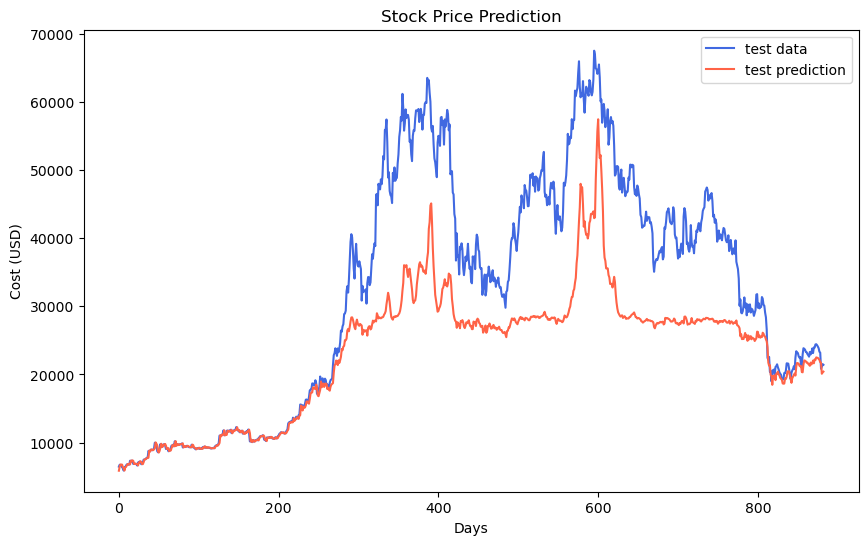

In [34]:
fig = plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(y_test), color='royalblue', label='test data')
plt.plot(scaler.inverse_transform(y_test_pred.reshape(-1,1)), color='tomato', label='test prediction')
plt.title('Bitcoin Price Prediction')
plt.ylabel('Cost (USD)')
plt.xlabel('Days')
plt.legend()
plt.savefig('figures/lr/test_prediction.png')

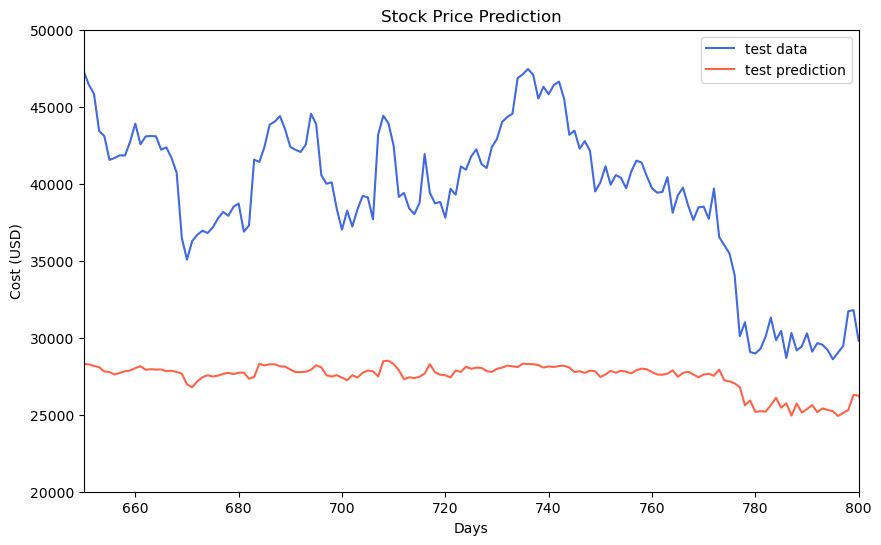

In [35]:
fig = plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(y_test), color='royalblue', label='test data')
plt.plot(scaler.inverse_transform(y_test_pred.reshape(-1,1)), color='tomato', label='test prediction')
plt.title('Stock Price Prediction')
plt.ylabel('Cost (USD)')
plt.xlabel('Days')
plt.legend()
plt.xlim(left=650, right=800)
plt.ylim(bottom=20000, top=50000)
plt.savefig('figures/lr/test_prediction_zoom.png')